# imports

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import mediapipe as mp

from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# file processing

In [2]:
images =[]
labels = []

dataset_path = './asl_dataset'

for subfolder in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, subfolder)
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
        labels.append(subfolder)

print(f"Loaded {len(images)} files.")

Loaded 2515 files.


In [3]:
df = pd.DataFrame({'image': images, 'label': labels})
df

image label
0     ./asl_dataset\0\hand1_0_bot_seg_1_cropped.jpeg     0
1     ./asl_dataset\0\hand1_0_bot_seg_2_cropped.jpeg     0
2     ./asl_dataset\0\hand1_0_bot_seg_3_cropped.jpeg     0
3     ./asl_dataset\0\hand1_0_bot_seg_4_cropped.jpeg     0
4     ./asl_dataset\0\hand1_0_bot_seg_5_cropped.jpeg     0
...                                              ...   ...
2510  ./asl_dataset\z\hand5_z_dif_seg_1_cropped.jpeg     z
2511  ./asl_dataset\z\hand5_z_dif_seg_2_cropped.jpeg     z
2512  ./asl_dataset\z\hand5_z_dif_seg_3_cropped.jpeg     z
2513  ./asl_dataset\z\hand5_z_dif_seg_4_cropped.jpeg     z
2514  ./asl_dataset\z\hand5_z_dif_seg_5_cropped.jpeg     z

[2515 rows x 2 columns]

In [4]:
df['label'].describe()

count     2515
unique      36
top          0
freq        70
Name: label, dtype: object

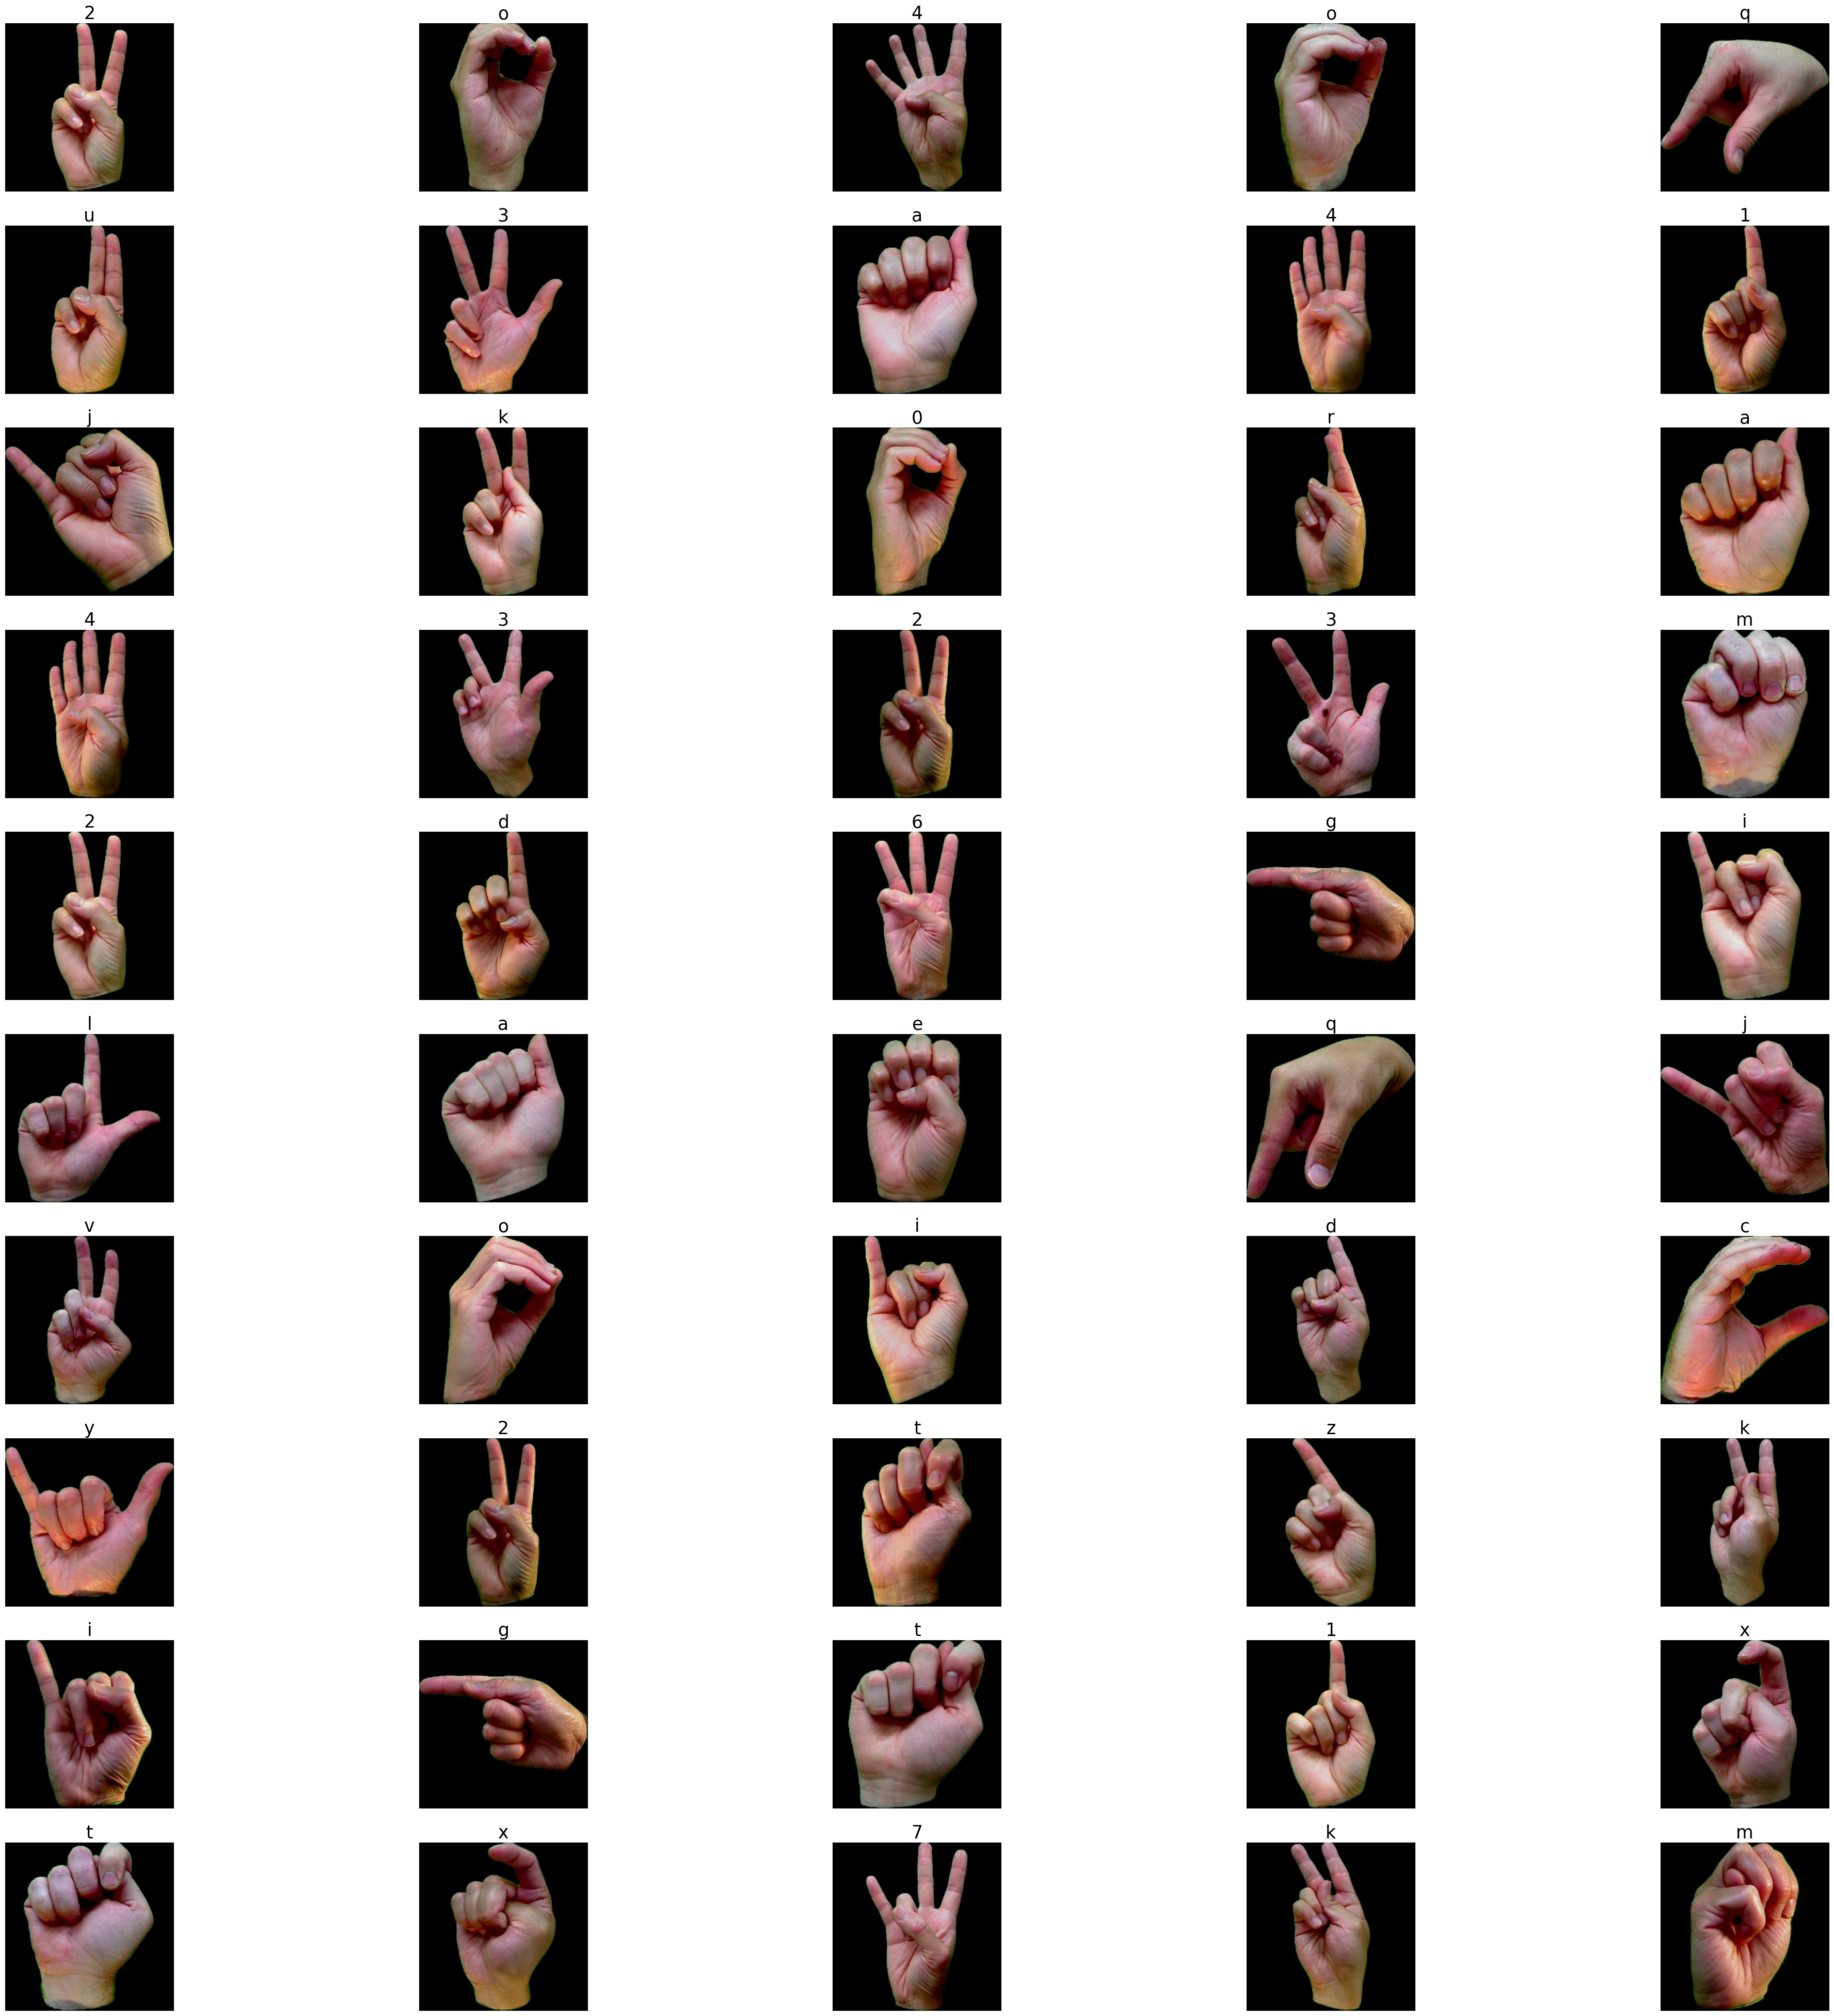

In [5]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

# Data Processing

In [6]:
def preprocess_images(image_paths):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, (224, 224))  # Resize to 224x224
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = img / 255.0  # Normalize pixel values to [0, 1]
        images.append(img)
    return np.array(images)

# Spliting Data



In [7]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [8]:
train_size = int(0.7 * len(df))  # 70% for training
val_size = int(0.15 * len(df))   # 15% for validation
test_size = len(df) - train_size - val_size  # 15% for testing

In [9]:
train_df = df[:train_size]
val_df = df[train_size:train_size + val_size]
test_df = df[train_size + val_size:]

In [10]:
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 1760
Validation set size: 377
Test set size: 378


In [11]:
print("Train set label distribution:")
print(train_df['label'].value_counts())

print("Validation set label distribution:")
print(val_df['label'].value_counts())

print("Test set label distribution:")
print(test_df['label'].value_counts())

Train set label distribution:
label
4    61
8    55
3    55
q    54
s    52
k    52
6    52
v    52
f    51
j    51
7    51
m    51
i    50
d    50
o    50
n    50
e    49
r    49
p    49
u    48
h    47
0    47
5    47
2    47
y    46
a    46
x    46
w    46
b    46
l    45
t    45
z    45
c    45
9    45
1    44
g    41
Name: count, dtype: int64
Validation set label distribution:
label
1    18
h    16
a    16
u    16
c    15
j    13
5    13
0    13
x    12
m    12
w    12
g    11
r    11
i    11
b    11
d    11
7    11
z    11
6    10
s    10
v    10
9     9
q     9
e     9
n     9
k     9
2     9
3     9
t     8
y     8
l     8
f     7
p     7
o     6
4     4
8     3
Name: count, dtype: int64
Test set label distribution:
label
g    18
l    17
9    16
y    16
p    14
2    14
z    14
o    14
b    13
f    12
x    12
w    12
t    12
8    12
e    12
n    11
5    10
c    10
r    10
0    10
k     9
d     9
i     9
1     8
7     8
6     8
a     8
v     8
s     8
m     7
q     7
h     7
3   

# Model

## Prepare Data

In [12]:
# Separate image paths (X) and labels (y)
X_train = train_df['image'].values
y_train = train_df['label'].values

X_val = val_df['image'].values
y_val = val_df['label'].values

X_test = test_df['image'].values
y_test = test_df['label'].values

In [13]:
X_train_processed = preprocess_images(X_train)
X_val_processed = preprocess_images(X_val)
X_test_processed = preprocess_images(X_test)

In [14]:
# one-hot encoding
lb = LabelBinarizer()
y_train_encoded = lb.fit_transform(y_train)
y_val_encoded = lb.transform(y_val)
y_test_encoded = lb.transform(y_test)

In [15]:
# X- (num_samples, height, width, channels-RGB)
# y- (num_samples, num_classes-labels)
print(f"X_train shape: {X_train_processed.shape}")
print(f"y_train shape: {y_train_encoded.shape}")
print(f"X_val shape: {X_val_processed.shape}")
print(f"y_val shape: {y_val_encoded.shape}")
print(f"X_test shape: {X_test_processed.shape}")
print(f"y_test shape: {y_test_encoded.shape}")

X_train shape: (1760, 224, 224, 3)
y_train shape: (1760, 36)
X_val shape: (377, 224, 224, 3)
y_val shape: (377, 36)
X_test shape: (378, 224, 224, 3)
y_test shape: (378, 36)


## MediaPipe Hands

In [16]:
def extract_hand_landmarks(image_paths):
    """
    Extract hand landmarks from images using MediaPipe Hands.
    If no hand is detected, return None for that image.
    """
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.7)
    mp_drawing = mp.solutions.drawing_utils

    landmarks = []
    for path in image_paths:
        img = cv2.imread(path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = hands.process(img_rgb)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                # Flatten landmark coordinates
                landmark_list = []
                for lm in hand_landmarks.landmark:
                    landmark_list.extend([lm.x, lm.y, lm.z])
                landmarks.append(landmark_list)
        else:
            # Append None if no hand is detected
            landmarks.append(None)

    hands.close()
    return np.array(landmarks, dtype=object)


In [17]:
# Extract hand landmarks
train_landmarks = extract_hand_landmarks(X_train)
val_landmarks = extract_hand_landmarks(X_val)
test_landmarks = extract_hand_landmarks(X_test)

# Remove samples where landmarks are None
def filter_valid_landmarks(landmarks, labels):
    valid_indices = [i for i, lm in enumerate(landmarks) if lm is not None]
    return landmarks[valid_indices], labels[valid_indices]

train_landmarks, y_train_encoded = filter_valid_landmarks(train_landmarks, y_train_encoded)
val_landmarks, y_val_encoded = filter_valid_landmarks(val_landmarks, y_val_encoded)
test_landmarks, y_test_encoded = filter_valid_landmarks(test_landmarks, y_test_encoded)


In [24]:
# Ensure train_landmarks is a clean NumPy array
train_landmarks = np.array([lm for lm in train_landmarks if lm is not None])
val_landmarks = np.array([lm for lm in val_landmarks if lm is not None])
test_landmarks = np.array([lm for lm in test_landmarks if lm is not None])

In [25]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(train_landmarks.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train_encoded.shape[1], activation='softmax')  # Number of classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 128)                 │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 36)                  │           2,340 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,788 (73.39 KB)

 Trainable params: 18,788 (73.39 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = model.fit(
    np.array(train_landmarks), np.array(y_train_encoded),
    validation_data=(np.array(val_landmarks), np.array(y_val_encoded)),
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0333 - loss: 3.5942 - val_accuracy: 0.0743 - val_loss: 3.3993
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.0644 - loss: 3.3656 - val_accuracy: 0.0743 - val_loss: 3.2484
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - accuracy: 0.1156 - loss: 3.2234 - val_accuracy: 0.2129 - val_loss: 3.0861
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1875 - loss: 3.0293 - val_accuracy: 0.2723 - val_loss: 2.8714
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.2032 - loss: 2.8907 - val_accuracy: 0.4703 - val_loss: 2.5975
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - accuracy: 0.2942 - loss: 2.5658 - val_accuracy: 0.4653 - val_loss: 2.3261
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3401 - loss: 2.3307 - val_accuracy: 0.5248 - val_loss: 2.0625
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3735 - loss: 2.1450 - val_accuracy: 0.5248 - v

# Evaluate

In [28]:
test_loss, test_accuracy = model.evaluate(np.array(test_landmarks), np.array(y_test_encoded))
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - accuracy: 0.9226 - loss: 0.5033
Test Accuracy: 90.87%


# Visualize

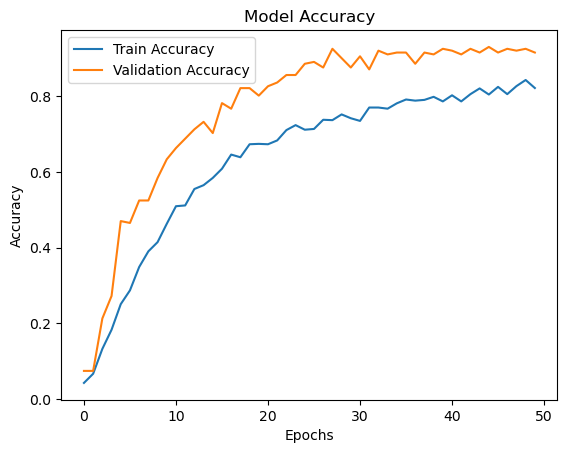

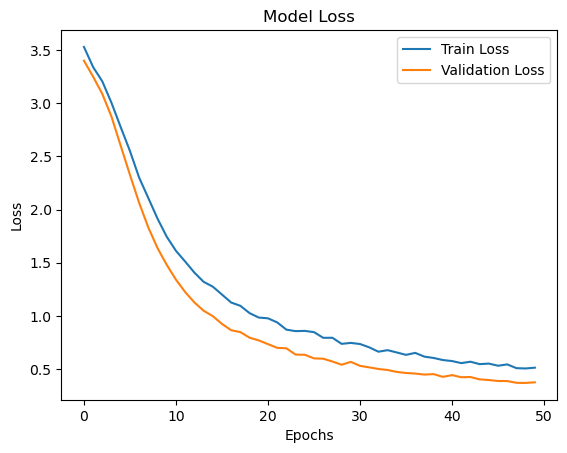

In [30]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
